# FNN Linus Etemi

## Imports


In [410]:
TYPE = 'GPU'

if TYPE == 'CPU':
    import numpy as np
else:
    import cupy as np
    
import scipy.special
import math
import matplotlib
import matplotlib.pyplot as matplot
import pickle

from ray import tune
from csv import writer


## Config

In [411]:
#hiddennodes_start = 800
#hiddennodes_stop = 800
#hiddennodes_step = 100

#learningrate_start = 0.08
#learningrate_stop = 0.08
#learningrate_step = 0.01

#epochs_start = 1
#epochs_stop = 2
#epochs_step = 0

outputnodes = 10
hiddennodes = 900
learningrate = 0.05
inputnodes = 784
epochs= 23


## Neuronales Netz 

In [412]:
class neuralNetwork:
    def __init__(self, innodes, outnodes, hidnodes, learningrate, epochs):
        self.inodes = innodes
        self.onodes = outnodes
        self.hnodes = hidnodes
        self.lr = learningrate
        self.epo = epochs
        self.wih = ((np.random.rand(self.hnodes,self.inodes)*2)-1)
        self.who = ((np.random.rand(self.onodes,self.hnodes)*2)-1)
        pass
    
    def activation_function(self, z: int) -> classmethod:
        return 1 / (1 + np.exp(-z))

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)

        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors) 
        self.who += self.lr * np.dot( (output_errors*final_outputs*(1.0-final_outputs)), np.transpose(hidden_outputs)) 
        self.wih += self.lr * np.dot( (hidden_errors*hidden_outputs*(1.0-hidden_outputs)), np.transpose(inputs)) 
        pass

    def query(self, input_list):
        inputs = np.array(input_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    

    

In [413]:
def clear_content(fname: str) -> None:
    file = open(fname, "w+")
    file.close

## Train_Network

In [414]:
def train_network(n, epo): 
        #clear_content('mnist_second_train.csv')
        training_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()

        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')

                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n.train(inputs, targets)

                pass
            pass

## Train_Network 2


In [415]:
# def train_network2(n, epo):  
#     for i in range (1, 100):
#         training_data_file = open('./MNISTData_2nd/mnist_second_train'+str(i)+'.csv', 'r')
#         training_data_list = training_data_file.readlines()
#         training_data_file.close()
#         for e in range(epo):
#             for record in training_data_list:
#                 all_values = record.split(',')
#                 inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
#                 targets = np.zeros(outputnodes) + 0.01
#                 targets[int(all_values[0])] = 0.99
#                 n.train(inputs, targets)

#                 pass
#             pass
#         pickle.dump(n, open('./MNISTNet_2nd/neural_network_'+str(i)+'.obj', 'wb'))



In [416]:
def train_network2(n2, epo, counter):  
        training_data_file = open('./MNISTData_2nd/mnist_second_train.csv', 'r')
        training_data_list = training_data_file.readlines()
        training_data_file.close()
        for e in range(epo):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
                targets = np.zeros(outputnodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n2.train(inputs, targets)
                pass
            pass
        pickle.dump(n2, open('./MNISTNet_2nd/neural_network_'+str(counter)+'.obj', 'wb'))

## Test_Network1 & Train_Network2

In [417]:
def test_network(n):

    test_data_file = open("./MNISTData_red/mnist_train_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    array_data_all = []
    scorecard_N_plus = []    
    scorecard_N_1R = []
    n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)   
    counter = 0

    for i in range(100):
        array_data_all.append([])
        scorecard_N_plus.append([])
        scorecard_N_1R.append([])

    for threshold in range(100):
        clear_content('./MNISTData_2nd/mnist_second_train.csv')
        for record in test_data_list:
            all_values = record.rstrip('\n').split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
            outputs = n.query(inputs)
            label_max = outputs[np.argmax(outputs)]
            label = np.argmax(outputs)
            if(label_max > (threshold/100)):
                scorecard_N_plus[threshold].append(1)
                if(label == correct_label):
                    scorecard_N_1R[threshold].append(1)
                else:
                    scorecard_N_1R[threshold].append(0)
            else:
                scorecard_N_plus[threshold].append(0)
                append_list_as_row('./MNISTData_2nd/mnist_second_train.csv', all_values)
            
        train_network2(n2, epochs, counter)
        counter += 1

    
    #append_list_as_row('./MNISTData_2nd/mnist_second_train'+str(threshold)+'.csv', all_values)
    # for i in range(100):
    #     scorecard_N_plus_array = np.asarray(scorecard_N_plus[i])
    #     scorecard_N_1R_array = np.asarray(scorecard_N_1R[i])

    #     array_data_all[i].append(i/100)
    #     array_data_all[i].append('N_+: {}'.format(scorecard_N_plus_array.sum()))
    #     array_data_all[i].append('N_+_size: {}'.format(scorecard_N_plus_array.size))
    #     array_data_all[i].append('N_1R: {:.5f}'.format(scorecard_N_1R_array.sum()))


    # return array_data_all

## Gesamttest


In [418]:
def test_network2(n1, n2):
    test_data_file = open("./mnist_test_red_8_9_by_90P.csv", 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()

    N_plus = []
    N_minus = []
    N_1R= []
    N_2R = []
    N_1F = []

    for threshold in range(100):
        for record in test_data_list:
            all_values = record.split(',')
            correct_label = int(all_values[0])
            inputs = (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01
            outputs_n1 = n1.query(inputs)
            label_n1 = np.argmax(outputs_n1)
            label_n1_max = outputs_n1(np.argmax(outputs_n1))
            outputs_n2 = n2.query(inputs)
            label_n2 = np.argmax(outputs_n2)

            if(label_n1_max > (threshold/100)):
                N_plus[threshold].append(1)
                if(label_n1 == correct_label):
                    N_1R[threshold].append(1)
                else:
                    N_1F[threshold].append(0)
                    if(label_n2 == correct_label):
                        N_2R[threshold].append(1)
            else:
                N_minus[threshold].append(0)


        P = N_plus/(N_plus+N_minus)
        Q = N_1R/N_plus
        X = (N_1R+N_2R)/(N_plus+N_minus)

    N_2R_array = np.asarray(N_2R)
    performance2 = N_2R_array.sum() / N_2R_array.size

    return performance2

## CSV Writer und Grid Search

In [419]:
def append_list_as_row(fname,list_of_elem):
    with open(fname, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)

In [420]:
#learningrate_i = learningrate_start
#hiddennodes_i = hiddennodes_start
#epochs_i = epochs_start


#while epochs_i <= epochs_stop:
#    while hiddennodes_i <= hiddennodes_stop:
#        while learningrate_i <= learningrate_stop:
#            intermediate_score = neuralNetwork(784,10,hiddennodes_i,learningrate_i,epochs_i).test_train()
#            print('Epoch [{:02d}/{:02d}]     | Hidden_Nodes [{:04d}/{:04d}]     | Learning_Rate [{:.2f}/{:.2f}]     | Performance: {:.5f}'.format(epochs_i,epochs_stop,hiddennodes_i,hiddennodes_stop,learningrate_i,learningrate_stop,intermediate_score))
#            append_list_as_row([784,10,hiddennodes_i,learningrate_i,epochs_i,intermediate_score])
#            learningrate_i += learningrate_step 
#        learningrate_i = learningrate_start    
#        hiddennodes_i += hiddennodes_step
#        print("========================================================")
#    hiddennodes_i = hiddennodes_start
#    epochs_i += epochs_step
#    print("========================================================")

## Scoring und Aufruf von Beiden Netzen

In [ ]:
#epochs = 23
#n1 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
#train_network(n1, epochs)
#pickle.dump(n1, open('./MNISTNet_1st/neural_network_1.obj', 'wb'))
# n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))
# test_network(n1)

In [421]:
#epochs = 7
intermediate_score_card = []
#n2 = neuralNetwork(784,10,hiddennodes,learningrate,epochs)
#train_network2(n2, epochs)
n1 = pickle.load(open('./MNISTNet_1st/neural_network_1.obj', 'rb'))

for i in range (0,99):
    n2 = pickle.load(open('./MNISTNet_2nd/neural_network_'+str(i)+'.obj', 'rb'))
    intermediate_score2 = test_network2(n1, n2)
    intermediate_score_card.append(intermediate_score2)
    


## Plotting

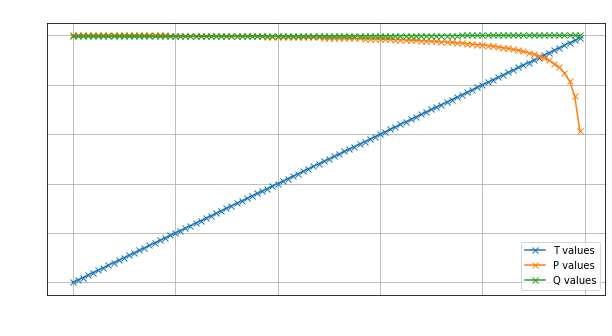

In [422]:
l = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
t_values = []
p_values = []
q_values = []
x_values = []
import numpy as np

for i in range(100):
    speicher = intermediate_score1[i]
    t_values.append(speicher[0])
    p_values.append(speicher[1])
    q_values.append(speicher[2])

p_int_values = [s.replace("N_+:","")for s in p_values]
p_int_values = list(map(float, p_int_values))
q_int_values = [t.replace("N_1R:","")for t in q_values]
q_int_values = list(map(float, q_int_values))
N = len(t_values)
l2 = np.arange(N)

with matplot.rc_context({'axes.edgecolor': 'black', 'xtick.color':'white','ytick.color':'white'}):
    matplot.subplots(figsize=(10,5))
    matplot.plot(l2, t_values, marker= 'x',label='T values')
    matplot.plot(l2, p_int_values,marker= 'x', label='P values')
    matplot.plot(l2, q_int_values, marker= 'x',label='Q values')

    matplot.grid(True)
    matplot.xlabel("%", fontsize = 12, color = 'white')
    matplot.colorbar
    matplot.ylabel("%", fontsize = 12, color = 'white')
    matplot.legend()
    matplot.title("P & Q & T Values", fontsize = 12, color = 'white')
    matplot.show()


